In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad

In [4]:
embed_path = "/Users/apple/Desktop/KB/data/feat_LCL_final/cell_tag_cell_tag_multi"

cell_tag = ad.read_h5ad("/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cellTag_train_tag_Seurat.h5ad")
proj_embed = np.load(embed_path+"/feat_celltagMulti_lambda005_unlab50_bs250_testAsPenalty/test_proj_embed.npy")
cell_tag.obsm["X_lcl"] = proj_embed
cell_tag.obsm["X_integrate"] = cell_tag.X


cell_tag_multi = ad.read_h5ad("/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cellTag_test_multi_Seurat_clone_id.h5ad")
proj_embed_multi = np.load(embed_path+"/feat_celltagMulti_lambda005_unlab50_bs250_testAsPenalty/train_proj_embed.npy")
cell_tag_multi.obsm["X_lcl"] = proj_embed_multi



In [6]:
cell_tag.obsm["X_lcl"].shape

(6534, 32)

In [ ]:
# lineage_transfer_eval.py
# Complete pipeline for: (1) clustering unlabeled/test cells in an embedding,
# (2) GEMLI-style random-pair evaluation of "same lineage" via TPR/FPR,
# (3) optional baseline embedding comparison,
# (4) Leiden resolution sweep + summary table,
# (5) optional plotting utilities.


# -----------------------------
# Core helpers
# -----------------------------

def cluster_in_embedding(
    adata,
    embedding_key,
    cluster_key,
    resolution=1.0,
    n_neighbors=30,
    random_state=0,
):
    """
    Cluster cells using Leiden on a precomputed embedding stored in adata.obsm[embedding_key].

    Parameters
    ----------
    adata : AnnData
    embedding_key : str
        Key in adata.obsm where embedding is stored.
    cluster_key : str
        Column name in adata.obs where Leiden clusters will be stored.
    resolution : float
        Leiden resolution.
    n_neighbors : int
        kNN graph size for Scanpy neighbors.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    adata : AnnData (modified in-place)
    """
    if embedding_key not in adata.obsm:
        raise KeyError(f"{embedding_key} not found in adata.obsm. Available: {list(adata.obsm.keys())}")

    sc.pp.neighbors(
        adata,
        use_rep=embedding_key,
        n_neighbors=n_neighbors,
        random_state=random_state,
    )
    sc.tl.leiden(
        adata,
        resolution=resolution,
        key_added=cluster_key,
        random_state=random_state,
    )
    return adata


def _sample_pairs_no_self(n_cells, n_pairs, rng):
    """
    Sample n_pairs unordered pairs (i, j) with i != j uniformly (approx) by rejection on j==i.
    """
    i = rng.integers(0, n_cells, size=n_pairs)
    j = rng.integers(0, n_cells, size=n_pairs)
    mask = (i == j)
    while np.any(mask):
        j[mask] = rng.integers(0, n_cells, size=np.sum(mask))
        mask = (i == j)
    return i, j


def evaluate_pairwise_tpr_fpr(
    adata,
    lineage_key="clone_id",
    cluster_key="pred_cluster",
    n_pairs=100_000,
    random_state=0,
    restrict_nonmissing=True,
):
    """
    GEMLI-style evaluation:
      Truth:   same lineage (adata.obs[lineage_key])
      Pred:    same cluster (adata.obs[cluster_key])

    Returns TP, FN, FP, TN, TPR, FPR.
    """
    if lineage_key not in adata.obs:
        raise KeyError(f"{lineage_key} not found in adata.obs.")
    if cluster_key not in adata.obs:
        raise KeyError(f"{cluster_key} not found in adata.obs.")

    rng = np.random.default_rng(random_state)

    lineage = adata.obs[lineage_key].to_numpy()
    cluster = adata.obs[cluster_key].to_numpy()


    n_cells = adata.n_obs

    i, j = _sample_pairs_no_self(n_cells, n_pairs, rng)

    same_true = (lineage[i] == lineage[j])
    same_pred = (cluster[i] == cluster[j])

    TP = int(np.sum(same_true & same_pred))
    FN = int(np.sum(same_true & ~same_pred))
    FP = int(np.sum(~same_true & same_pred))
    TN = int(np.sum(~same_true & ~same_pred))

    tpr = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    fpr = FP / (FP + TN) if (FP + TN) > 0 else np.nan

    return {
        "TP": TP,
        "FN": FN,
        "FP": FP,
        "TN": TN,
        "TPR": float(tpr),
        "FPR": float(fpr),
        "n_pairs": int(n_pairs),
        "n_cells_used": int(n_cells),
        "lineage_key": lineage_key,
        "cluster_key": cluster_key,
    }


# -----------------------------
# Main deployment wrapper
# -----------------------------

def deploy_lineage_prediction_on_unlabeled(
    adata_test,
    lineage_key="clone_id",
    lcl_embedding_key="X_lcl",
    baseline_embedding_key=None,
    lcl_cluster_key="lcl_cluster",
    baseline_cluster_key="baseline_cluster",
    lcl_resolution=1.0,
    baseline_resolution=1.0,
    n_pairs=100_000,
    n_neighbors=30,
    random_state=0,
    restrict_nonmissing=True,
    verbose=True,
):
    """
    1) Cluster unlabeled/test cells using Leiden in the LCL embedding.
    2) Evaluate pairwise TPR/FPR via random pair sampling.
    3) Optionally repeat for a baseline embedding.

    Returns dict with results.
    """
    results = {}

    # --- LCL embedding ---
    cluster_in_embedding(
        adata_test,
        embedding_key=lcl_embedding_key,
        cluster_key=lcl_cluster_key,
        resolution=lcl_resolution,
        n_neighbors=n_neighbors,
        random_state=random_state,
    )
    res_lcl = evaluate_pairwise_tpr_fpr(
        adata_test,
        lineage_key=lineage_key,
        cluster_key=lcl_cluster_key,
        n_pairs=n_pairs,
        random_state=random_state,
        restrict_nonmissing=restrict_nonmissing,
    )
    res_lcl.update({
        "method": "LCL",
        "embedding_key": lcl_embedding_key,
        "resolution": float(lcl_resolution),
        "n_neighbors": int(n_neighbors),
    })
    results["LCL"] = res_lcl

    if verbose:
        print("LCL-based prediction:")
        print(res_lcl)

    # --- Baseline embedding (optional) ---
    if baseline_embedding_key is not None:
        cluster_in_embedding(
            adata_test,
            embedding_key=baseline_embedding_key,
            cluster_key=baseline_cluster_key,
            resolution=baseline_resolution,
            n_neighbors=n_neighbors,
            random_state=random_state,
        )
        res_base = evaluate_pairwise_tpr_fpr(
            adata_test,
            lineage_key=lineage_key,
            cluster_key=baseline_cluster_key,
            n_pairs=n_pairs,
            random_state=random_state + 1,
            restrict_nonmissing=restrict_nonmissing,
        )
        res_base.update({
            "method": "baseline",
            "embedding_key": baseline_embedding_key,
            "resolution": float(baseline_resolution),
            "n_neighbors": int(n_neighbors),
        })
        results["baseline"] = res_base

        if verbose:
            print("\nBaseline-embedding prediction:")
            print(res_base)

    return results


# -----------------------------
# Resolution sweep (recommended)
# -----------------------------

def sweep_leiden_resolutions(
    adata_test,
    lineage_key="clone_id",
    lcl_embedding_key="X_lcl",
    baseline_embedding_key=None,
    resolutions=(0.2, 0.5, 1.0, 1.5, 2.0),
    n_pairs=100_000,
    n_neighbors=30,
    random_state=0,
    restrict_nonmissing=True,
    verbose=False,
):
    """
    Sweep Leiden resolution values and compute TPR/FPR for LCL (and optionally baseline).
    Returns a tidy pandas DataFrame.

    Note: modifies adata_test.obs by adding cluster columns for each resolution.
    """
    rows = []

    for r in resolutions:
        lcl_cluster_key = f"lcl_leiden_r{r}".replace(".", "p")
        base_cluster_key = f"base_leiden_r{r}".replace(".", "p")

        res = deploy_lineage_prediction_on_unlabeled(
            adata_test=adata_test,
            lineage_key=lineage_key,
            lcl_embedding_key=lcl_embedding_key,
            baseline_embedding_key=baseline_embedding_key,
            lcl_cluster_key=lcl_cluster_key,
            baseline_cluster_key=base_cluster_key,
            lcl_resolution=r,
            baseline_resolution=r,
            n_pairs=n_pairs,
            n_neighbors=n_neighbors,
            random_state=random_state,
            restrict_nonmissing=restrict_nonmissing,
            verbose=verbose,
        )

        rows.append({
            "resolution": float(r),
            "method": "LCL",
            "TPR": res["LCL"]["TPR"],
            "FPR": res["LCL"]["FPR"],
            "TP": res["LCL"]["TP"],
            "FP": res["LCL"]["FP"],
            "FN": res["LCL"]["FN"],
            "TN": res["LCL"]["TN"],
            "n_pairs": res["LCL"]["n_pairs"],
            "n_neighbors": int(n_neighbors),
            "embedding_key": lcl_embedding_key,
            "cluster_key": lcl_cluster_key,
        })

        if "baseline" in res:
            rows.append({
                "resolution": float(r),
                "method": "baseline",
                "TPR": res["baseline"]["TPR"],
                "FPR": res["baseline"]["FPR"],
                "TP": res["baseline"]["TP"],
                "FP": res["baseline"]["FP"],
                "FN": res["baseline"]["FN"],
                "TN": res["baseline"]["TN"],
                "n_pairs": res["baseline"]["n_pairs"],
                "n_neighbors": int(n_neighbors),
                "embedding_key": baseline_embedding_key,
                "cluster_key": base_cluster_key,
            })

    df = pd.DataFrame(rows).sort_values(["method", "resolution"]).reset_index(drop=True)
    return df


def tpr_at_matched_fpr(df, target_fpr=0.05):
    """
    Convenience: for each method, find the resolution whose FPR is closest to target_fpr,
    and report TPR there.
    """
    out = []
    for method in df["method"].unique():
        sub = df[df["method"] == method].copy()
        sub["fpr_dist"] = (sub["FPR"] - target_fpr).abs()
        best = sub.sort_values("fpr_dist").iloc[0]
        out.append({
            "method": method,
            "target_fpr": float(target_fpr),
            "chosen_resolution": float(best["resolution"]),
            "TPR": float(best["TPR"]),
            "FPR": float(best["FPR"]),
        })
    return pd.DataFrame(out)


# -----------------------------
# Optional plotting (matplotlib only)
# -----------------------------
def plot_tpr_fpr_curve(df, title="TPR vs FPR across Leiden resolutions"):
    """
    Plot TPR-FPR curves for each method across resolutions.
    Uses matplotlib without specifying colors (per your environment constraints).
    """
    import matplotlib.pyplot as plt

    plt.figure()
    for method in df["method"].unique():
        sub = df[df["method"] == method].sort_values("resolution")
        plt.plot(sub["FPR"], sub["TPR"], marker="o", label=method)

    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()




In [8]:
df = sweep_leiden_resolutions(
    adata_test=cell_tag,
    lineage_key="clone_id",
    lcl_embedding_key="X_lcl",
    baseline_embedding_key= "X_integrate",
    resolutions=(0.2, 0.5, 1.0, 1.5, 2.0),
    n_pairs=100_000,
    n_neighbors=10,
    random_state=42,
    verbose=False
)



/opt/anaconda3/envs/titan_env_py310/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/titan_env_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_33271/367567111.py:51: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

   resolution    method       TPR       FPR    TP     FP    FN     TN  \
0         0.2       LCL  0.228957  0.157126  1477  14699  4974  78850   
1         0.5       LCL  0.173927  0.116933  1122  10939  5329  82610   
2         1.0       LCL  0.101225  0.068114   653   6372  5798  87177   
3         1.5       LCL  0.067276  0.041700   434   3901  6017  89648   
4         2.0       LCL  0.054255  0.030861   350   2887  6101  90662   
5         0.2  baseline  1.000000  1.000000  6400  93600     0      0   
6         0.5  baseline  0.649844  0.635032  4159  59439  2241  34161   
7         1.0  baseline  0.338750  0.216976  2168  20309  4232  73291   
8         1.5  baseline  0.222969  0.145534  1427  13622  4973  79978   
9         2.0  baseline  0.110312  0.068226   706   6386  5694  87214   

   n_pairs  n_neighbors embedding_key       cluster_key  
0   100000           10         X_lcl   lcl_leiden_r0p2  
1   100000           10         X_lcl   lcl_leiden_r0p5  
2   100000           1

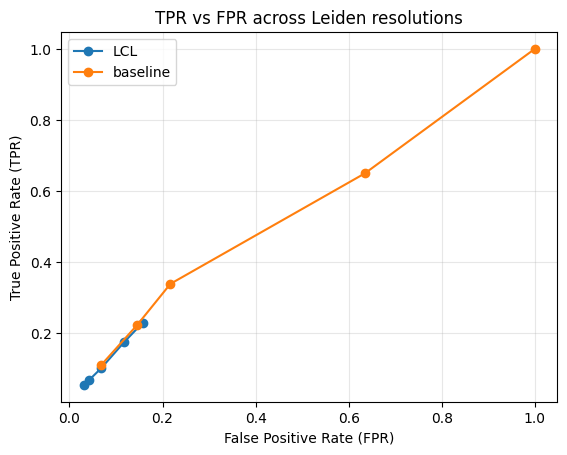

In [9]:
print(df)
print(tpr_at_matched_fpr(df, target_fpr=0.05))
plot_tpr_fpr_curve(df)